In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
from PIL import Image
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

<Axes: xlabel='Categories', ylabel='count'>

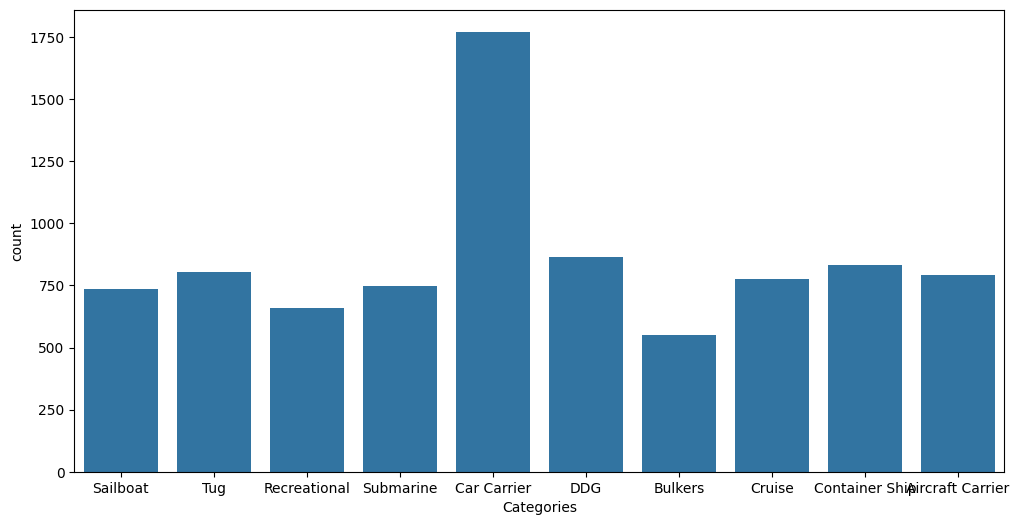

In [2]:
path = 'ships_dataset/train'
img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)
classes=[]
for folder, subfolders, filenames in os.walk(path):
  classes.append(subfolders)
  classes=classes[0]
  break
categorias=[]
for name in img_names:
  for classe in classes:
    if classe in name:
      categorias.append(classe)
plt.figure(figsize=[12,6])
sns.countplot(data=pd.DataFrame(categorias, columns=["Categories"]), x="Categories")
     

In [3]:
pd.DataFrame(categorias, columns=["Categories"]).value_counts(normalize=True)

Categories      
Car Carrier         0.207640
DDG                 0.101125
Container Ship      0.097492
Tug                 0.094094
Aircraft Carrier    0.092805
Cruise              0.091165
Submarine           0.087415
Sailboat            0.086360
Recreational        0.077338
Bulkers             0.064565
Name: proportion, dtype: float64

In [4]:
img_sizes = []
for item in img_names:
   with Image.open(item) as img:
    img_sizes.append(img.size)
data_img=pd.DataFrame(img_sizes)
data_img["size"]=data_img[0].astype(str)+"x"+data_img[1].astype(str)
data_img["size"].value_counts()

size
600x416      7406
1600x900       23
1200x675       19
1920x1080      18
300x168        17
             ... 
697x477         1
700x500         1
1900x1186       1
1099x661        1
2400x1706       1
Name: count, Length: 644, dtype: int64

In [5]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [8]:
root = '/home/sally/Projects/College/DL/ships_dataset'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)
valid_data = datasets.ImageFolder(os.path.join(root, 'valid'), transform=test_transform)
test_data=ConcatDataset([test_data, valid_data])

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)


class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['Aircraft Carrier', 'Bulkers', 'Car Carrier', 'Container Ship', 'Cruise', 'DDG', 'Recreational', 'Sailboat', 'Submarine', 'Tug']
Training images available: 8534
Testing images available:  1470


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Label: [    0     6     3     4     9     5     9     6     2     8]
Class:  Aircraft Carrier Recreational Container Ship Cruise Tug DDG Tug Recreational Car Carrier Submarine


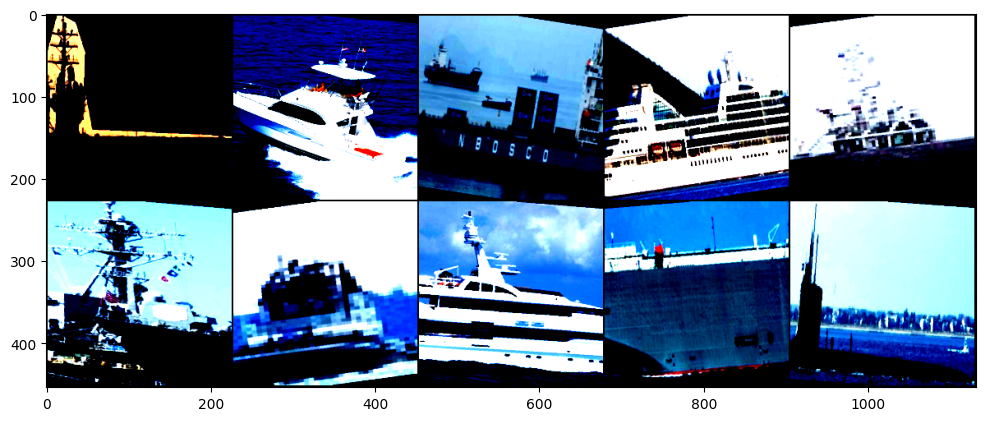

In [9]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader:
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(12,8))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [10]:
AlexNetmodel = models.alexnet(pretrained=True)
print(AlexNetmodel)
for param in AlexNetmodel.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/sally/.local/cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100.0%


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
torch.manual_seed(42)
AlexNetmodel.classifier = nn.Sequential(nn.Dropout(0.5),
                                        nn.Linear(9216, 4096),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(4096, 4096),
                                        nn.ReLU(),
                                        nn.Linear(4096, 10),
                                 nn.LogSoftmax(dim=1))
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

In [14]:
import time
start_time = time.time()

epochs = 3

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1

        # Apply the model
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/7629]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        AlexNetmodel.eval()
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model

            y_val = AlexNetmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()



    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
    AlexNetmodel.train()

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:  0  batch:  200 [  2000/7629]  loss: 0.61911166  accuracy:  70.200%
epoch:  0  batch:  400 [  4000/7629]  loss: 0.04355496  accuracy:  75.425%
epoch:  0  batch:  600 [  6000/7629]  loss: 1.54849124  accuracy:  78.417%
epoch:  0  batch:  800 [  8000/7629]  loss: 0.11629325  accuracy:  80.037%
epoch:  1  batch:  200 [  2000/7629]  loss: 0.14875653  accuracy:  86.300%
epoch:  1  batch:  400 [  4000/7629]  loss: 0.00474470  accuracy:  86.575%
epoch:  1  batch:  600 [  6000/7629]  loss: 0.59038204  accuracy:  86.533%
epoch:  1  batch:  800 [  8000/7629]  loss: 0.70344102  accuracy:  86.662%
epoch:  2  batch:  200 [  2000/7629]  loss: 0.91208804  accuracy:  88.550%
epoch:  2  batch:  400 [  4000/7629]  loss: 0.27675125  accuracy:  88.225%
epoch:  2  batch:  600 [  6000/7629]  loss: 0.23282187  accuracy:  88.967%
epoch:  2  batch:  800 [  8000/7629]  loss: 0.12323052  accuracy:  88.862%

Duration: 991 seconds


In [15]:
torch.save(AlexNetmodel.state_dict(), 'AlexNetmodel.pt')

In [16]:
tst_corr.item(),tst_corr.item()/1070

(1238, 1.1570093457943926)

In [17]:
test_loader = DataLoader(test_data, batch_size=1070, shuffle=True)
with torch.no_grad():
    AlexNetmodel.eval()
    for b, (X_test, y_test) in enumerate(test_loader):
       # Apply the model

        y_val = AlexNetmodel(X_test)

        # Tally the number of correct predictions
        predicted = torch.max(y_val.data, 1)[1]


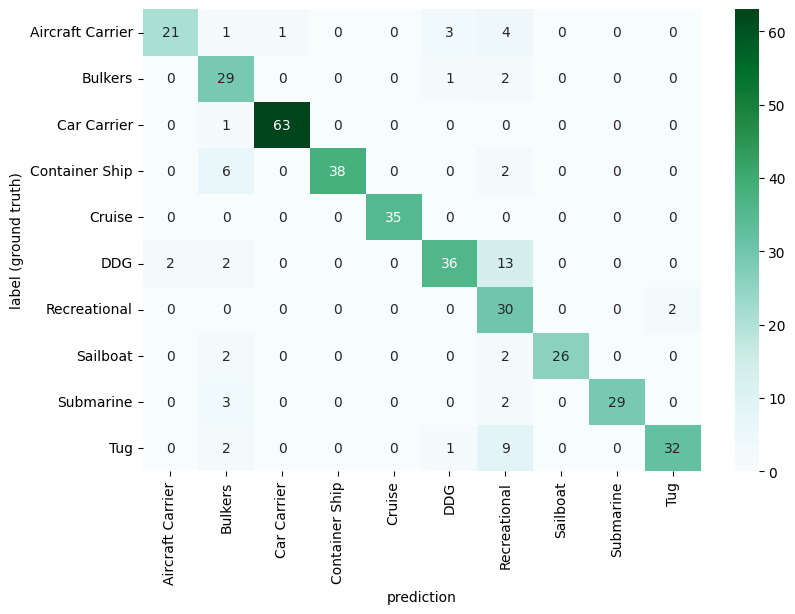

In [18]:
arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [19]:
print(classification_report(y_test.view(-1), predicted.view(-1),target_names=class_names))

                  precision    recall  f1-score   support

Aircraft Carrier       0.91      0.70      0.79        30
         Bulkers       0.63      0.91      0.74        32
     Car Carrier       0.98      0.98      0.98        64
  Container Ship       1.00      0.83      0.90        46
          Cruise       1.00      1.00      1.00        35
             DDG       0.88      0.68      0.77        53
    Recreational       0.47      0.94      0.62        32
        Sailboat       1.00      0.87      0.93        30
       Submarine       1.00      0.85      0.92        34
             Tug       0.94      0.73      0.82        44

        accuracy                           0.85       400
       macro avg       0.88      0.85      0.85       400
    weighted avg       0.90      0.85      0.86       400

